In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd
import os
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pickle

In [7]:
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [8]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

train_datagen = ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale=1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

holdout_datagen = ImageDataGenerator(rescale=1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)


Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.layers import DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

# Entry Flow
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Middle Flow
for _ in range(4):
    model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())

# Exit Flow
model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

# Output layer
model.add(Dense(29, activation='softmax'))

model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 64, 64, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 32, 32, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        16,51

 Total params: 132,125 (516.11 KB)

 Trainable params: 128,669 (502.61 KB)

 Non-trainable params: 3,456 (13.50 KB)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=8

history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-06 17:45:15.944639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.52205, expected 2.04843
2024-04-06 17:45:15.944702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1280: 3.68618, expected 3.21256
2024-04-06 17:45:15.944740: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8192: 2.56124, expected 1.61154
2024-04-06 17:45:15.944748: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8193: 4.15056, expected 3.20085
2024-04-06 17:45:15.944756: E external/local_xla/xla/service/gpu/buffer_compar

  2/245 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.0537 - loss: 3.3798   

I0000 00:00:1712425528.033595      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 39/245 ━━━━━━━━━━━━━━━━━━━━ 3:12 935ms/step - accuracy: 0.1641 - loss: 2.9951

2024-04-06 17:46:05.996287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4096: 2.69238, expected 1.90437
2024-04-06 17:46:05.996334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4097: 4.30053, expected 3.51253
2024-04-06 17:46:05.996353: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4098: 4.5599, expected 3.7719
2024-04-06 17:46:05.996366: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4099: 3.93979, expected 3.15178
2024-04-06 17:46:05.996377: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4100: 4.94954, expected 4.16154
2024-04-06 17:46:05.996387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4101: 5.32699, expected 4.53899
2024-04-06 17:46:05.996398: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4102: 5.84054, expected 5.05253
2024-04-06 17:46:05.996408: E extern

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5463 - loss: 1.6591

2024-04-06 17:51:20.234442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.31554, expected 2.40451
2024-04-06 17:51:20.234502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.08075, expected 3.16973
2024-04-06 17:51:20.234511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.72428, expected 2.81326
2024-04-06 17:51:20.234519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.22942, expected 2.3184
2024-04-06 17:51:20.234527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.0839, expected 3.17287
2024-04-06 17:51:20.234535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.24145, expected 4.33042
2024-04-06 17:51:20.234542: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.34281, expected 3.43179
2024-04-06 17:51:20.234550: E external/local_xla/xla/serv

245/245 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.5473 - loss: 1.6556 - val_accuracy: 0.0345 - val_loss: 5.6456
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 97s 389ms/step - accuracy: 0.9915 - loss: 0.0655 - val_accuracy: 0.0407 - val_loss: 10.1196
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 93s 371ms/step - accuracy: 0.9988 - loss: 0.0159 - val_accuracy: 0.9389 - val_loss: 0.2063
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 92s 368ms/step - accuracy: 0.9996 - loss: 0.0068 - val_accuracy: 0.9983 - val_loss: 0.0123
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 144s 378ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9997 - val_loss: 0.0031
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 96s 383ms/step - accuracy: 1.0000 - loss: 9.7532e-04 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 92s 368ms/step - accuracy: 1.0000 - loss: 6.7912e-04 - val_accuracy: 0.9999 - val_loss: 9.8426e-04
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 95s 379ms/step - accuracy: 1.0000 - loss: 

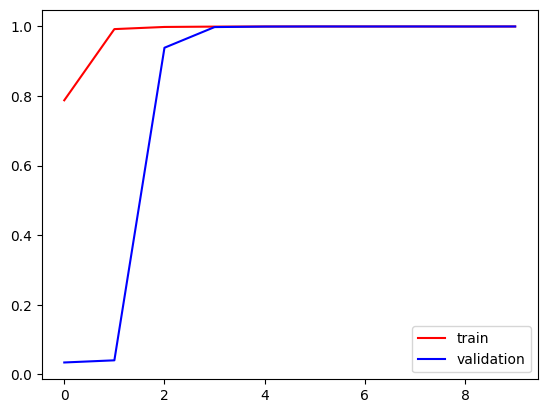

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

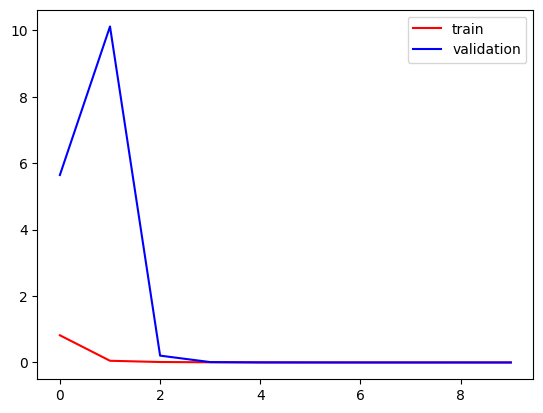

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [15]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2024-04-06 18:11:10.921969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.6517, expected 3.89452
2024-04-06 18:11:10.922032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.4732, expected 3.71602
2024-04-06 18:11:10.922049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.32145, expected 4.56428
2024-04-06 18:11:10.922066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.99975, expected 4.24258
2024-04-06 18:11:10.922077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.77102, expected 5.01385
2024-04-06 18:11:10.922087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.45793, expected 5.70076
2024-04-06 18:11:10.922099: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.03285, expected 5.27568
2024-04-06 18:11:10.922109: E external/local_xla/xla/serv

34/34 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       300
           B       1.00      1.00      1.00       300
           C       1.00      1.00      1.00       300
           D       1.00      1.00      1.00       300
           E       1.00      1.00      1.00       300
           F       1.00      1.00      1.00       300
           G       1.00      1.00      1.00       300
           H       1.00      1.00      1.00       300
           I       1.00      1.00      1.00       300
           J       1.00      1.00      1.00       300
           K       1.00      1.00      1.00       300
           L       1.00      1.00      1.00       300
           M       1.00      1.00      1.00       300
           N       1.00      1.00      1.00       300
           O       1.00      1.00      1.00       300
           P       1.00      1.00      1.00       300
           Q       1.00      1.00      1.0

In [18]:
model_json = model.to_json()
with open("aslrecognition.json",'w') as json_file:
    json_file.write(model_json)
model.save("aslrecognitionmodel.h5")
model.save_weights("aslrecognition.weights.h5")